In [12]:
import scanpy as sc
import numpy as np
# import matplotlib.pyplot as plt
import matplotlib as mpl
import cell2location
# import cell2location

from matplotlib import rcParams
import pandas as pd
import anndata
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text for PDFs

results_folder = './results/lymph_nodes_analysis'

# create paths and names to results folders for reference regression and cell2location models
ref_run_name = f'{results_folder}/reference_signatures'
run_name = f'{results_folder}/cell2location_map'
# This step needs to be changed according to the data format read. Here we use the normalized expression matrix and unprocessed metadata.
data_matrix = pd.read_csv("E:\\PostGraduate\\newInformation\\Merfish\\vz-ffpe-showcaseHumanBreastCancerPatient1\\cell_by_gene.csv", index_col=0)
metadata = pd.read_csv("E:\\PostGraduate\\newInformation\\Merfish\\vz-ffpe-showcaseHumanBreastCancerPatient1\\cell_metadata.csv", index_col=0)
print(data_matrix)
print(metadata)
adata_vis = anndata.AnnData(X=data_matrix.values, obs=metadata)

# This step can only be performed when there is an image in the input data
# adata_vis.obs['sample'] = list(adata_vis.uns['spatial'].keys())[0]
# print(adata_vis.var.head())

adata_vis.var['SYMBOL'] = adata_vis.var_names
# Set different indexes of the matrix. Some data use gene_ids, and others need to be set by yourself.
# adata_vis.var.set_index('gene_ids', drop=True, inplace=True)
adata_vis.var.set_index(data_matrix.columns, drop=True, inplace=True)

# Used when there is annotated celltype in the metadata data
# adata_vis.obs['celltype'] = adata_vis.var['SYMBOL'] 

# find mitochondria-encoded (MT) genes
adata_vis.var['MT_gene'] = [gene.startswith('MT-') for gene in adata_vis.var['SYMBOL']]

# remove MT genes for spatial mapping (keeping their counts in the object)
adata_vis.obsm['MT'] = adata_vis[:, adata_vis.var['MT_gene'].values].X.toarray()
adata_vis = adata_vis[:, ~adata_vis.var['MT_gene'].values]



        PDK4  CCL26  CX3CL1  PGLYRP1  CD4  SNAI2  TNFRSF17  ICAM3  TBX21  FAP  \
cell                                                                            
0        2.0    0.0     5.0      0.0  0.0    0.0       1.0    0.0    0.0  0.0   
1        0.0    0.0     0.0      0.0  0.0    0.0       0.0    0.0    0.0  0.0   
2        1.0    0.0     2.0      0.0  0.0    0.0       0.0    0.0    0.0  0.0   
3        0.0    0.0     4.0      0.0  0.0    0.0       1.0    0.0    0.0  0.0   
4        0.0    0.0     0.0      0.0  0.0    0.0       1.0    0.0    0.0  0.0   
...      ...    ...     ...      ...  ...    ...       ...    ...    ...  ...   
713116   0.0    0.0     0.0      0.0  1.0    0.0       1.0    0.0    0.0  0.0   
713117   0.0    0.0     0.0      0.0  1.0    0.0       0.0    0.0    0.0  0.0   
713118   0.0    0.0     2.0      0.0  1.0    0.0       0.0    0.0    0.0  1.0   
713119   4.0    0.0     2.0      0.0  0.0    0.0       0.0    0.0    0.0  0.0   
713120   0.0    0.0     0.0 

D:\Environment\Anaconda\envs\cell2Location\lib\site-packages\anndata\_core\aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [13]:
adata_vis.obs

,fov,volume,center_x,center_y,min_x,max_x,min_y,max_y
128421,0,547.841519,10996.346206,-211.315228,10991.189362,11001.503050,-215.639293,-206.991164
128422,0,291.101510,11103.182359,-209.935477,11099.334599,11107.030118,-213.992957,-205.877997
128425,0,489.978098,11007.296582,-209.592749,11002.998782,11011.594381,-213.726745,-205.458754
128426,0,654.037717,11106.932047,-207.366062,11100.501938,11113.362156,-212.213345,-202.518779
128427,0,861.329942,11061.537618,-205.607113,11055.883233,11067.192004,-211.373308,-199.840918
...,...,...,...,...,...,...,...,...
65971,2506,253.298603,10912.734782,9684.140608,10909.369309,10916.100255,9680.283133,9687.998083
65975,2506,1032.868835,10959.600377,9702.129593,10953.184042,10966.016711,9695.970477,9708.288709
65976,2506,623.721435,11058.036588,9703.663795,11050.739990,11065.333187,9696.464221,9710.863369
65983,2506,1236.109249,10944.921726,9740.012287,10937.940486,10951.902966,9733.007135,9747.017439


In [14]:

# Load the expression matrix and metadata of the reference set

data_matrix = pd.read_csv("E:\\PostGraduate\\newInformation\\Merfish\\data_matrix.csv", index_col=0)
metadata = pd.read_csv("E:\\PostGraduate\\newInformation\\Merfish\\metadata.csv", index_col=0)
# Used to unify the indexes between the reference set and the input data
ensemble = pd.read_csv("E:\\PostGraduate\\newInformation\\CRC\\ensemble.csv", index_col=0)


In [15]:
for oldIndex in data_matrix.index:
    try:
        newIndex = ensemble.loc[oldIndex]['ENSEMBL']
    except KeyError:
        continue 

    data_matrix.rename(index={oldIndex: newIndex}, inplace=True)


In [16]:
# Creating an AnnData object
adata = anndata.AnnData(X=data_matrix.transpose().values, obs=metadata)


In [17]:
adata.var.set_index(data_matrix.index, drop=True, inplace=True)



In [18]:
adata.obs

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,nCount_SCT,nFeature_SCT,SCT_snn_res.1,seurat_clusters,celltype,malignancy
BT1303_AACACGTTCCTCATTA,BT1303,1620.176298,768,2.526042,1887,768,31,31,B,Immune cells
BT1303_AACTCCCGTTCGGGCT,BT1303,1483.431668,653,2.654107,2030,653,31,31,B,Immune cells
BT1303_AAGCCGCGTATAGGTA,BT1303,3094.865622,4343,1.495704,1532,1173,5,5,B,Immune cells
BT1303_AAGGTTCGTTGGACCC,BT1303,1520.575443,620,2.394706,2005,620,31,31,B,Immune cells
BT1303_AAGTCTGCACACTGCG,BT1303,2797.540704,2485,1.135070,2926,2485,5,5,B,Immune cells
...,...,...,...,...,...,...,...,...,...,...
scrSOL006_TCTGAGAGTGGTGTAG,scrSOL006,3006.620434,2733,1.224386,3186,2727,7,7,Plasma,Immune cells
scrSOL006_TGAGGGATCCTCTAGC,scrSOL006,1807.248623,2706,1.422264,1532,1119,28,28,Plasma,Immune cells
scrSOL007_AGTTGGTTCACGGTTA,scrSOL007,2785.768634,2047,1.381624,2655,2047,2,2,Plasma,Immune cells
scrSOL007_CAACCTCCATTGAGCT,scrSOL007,2620.318701,5337,1.276942,1590,1171,6,6,Plasma,Immune cells


D:\Environment\Anaconda\envs\cell2Location\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


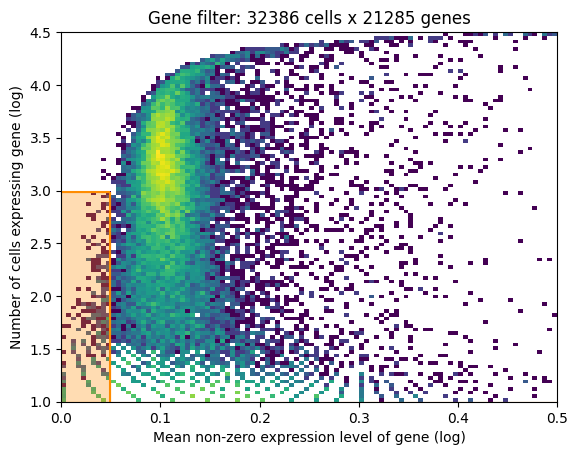

Anndata setup with scvi-tools version 1.1.2.

Setup via `RegressionModel.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'orig.ident',
│   'labels_key': 'celltype',
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │  10   │
│         n_cells          │ 32386 │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   8   │
│          n_vars          │ 21285 │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                     batch State Registry                     
┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location     ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['orig.ident'] │   BT1303   │          0          │
│                         │   BT1304   │          1          │
│                         │   BT1305   │          2          │
│                         │   BT1306   │          3          │
│                         │   BT1307   │          4          │
│                         │ scrSOL001  │          5          │
│                         │ scrSOL003  │          6          │
│                         │ scrSOL004  │          7          │
│                         │ scrSOL006  │          8          │
│                         │ scrSOL007  │          9          │
└─────────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location    ┃   Categories   ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['celltype'] │       B        │          0          │
│                       │      CD8T      │          1          │
│                       │  Endothelial   │          2          │
│                       │  Fibroblasts   │          3          │
│                       │   Malignant    │          4          │
│                       │   Mono/Macro   │          5          │
│                       │ Myofibroblasts │          6          │
│                       │     Plasma     │          7          │
└───────────────────────┴────────────────┴─────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
D:\Environment\Anaconda\envs\cell2Location\lib\site-packages\lightning\pytorch\trainer\configuration_validator.py:72: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
D:\Environment\Anaconda\envs\cell2Location\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 500/500: 100%|██████████| 500/500 [47:54<00:00,  4.71s/it, v_num=1, elbo_train=1.5e+8] 

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 500/500: 100%|██████████| 500/500 [47:54<00:00,  5.75s/it, v_num=1, elbo_train=1.5e+8]


In [20]:
adata_ref = adata


# delete unnecessary raw slot (to be removed in a future version of the tutorial)
del adata_ref.raw
from cell2location.utils.filtering import filter_genes
# Expressed in at least 5 genes Expressed in at least 3% of genes Average expression is 1.12
selected = filter_genes(adata_ref, cell_count_cutoff=5, cell_percentage_cutoff2=0.03, nonz_mean_cutoff=1.12)

# filter the object
adata_ref = adata_ref[:, selected].copy()

# prepare anndata for the regression model
cell2location.models.RegressionModel.setup_anndata(adata=adata_ref,
                        # 10X reaction / sample / batch
                        batch_key='orig.ident',
                        # cell type, covariate used for constructing signatures
                        # labels_key='feature_types', 
                        # The parameters here need to be modified according to the incoming data
                        labels_key='celltype',
                        # 两个协变量 multiplicative technical effects (platform, 3' vs 5', donor effect)
                        # categorical_covariate_keys=['Method'],
                        continuous_covariate_keys=None
                       )


from cell2location.models import RegressionModel
# Negative binomial model
mod = RegressionModel(adata_ref)  

# view anndata_setup as a sanity check
mod.view_anndata_setup()

mod.train(max_epochs=500, train_size=1)


Sampling global variables, sample: 100%|██████████| 999/999 [00:20<00:00, 48.55it/s]
['B', 'CD8T', 'Endothelial', 'Fibroblasts', 'Malignant', 'Mono/Macro', 'Myofibroblasts', 'Plasma']


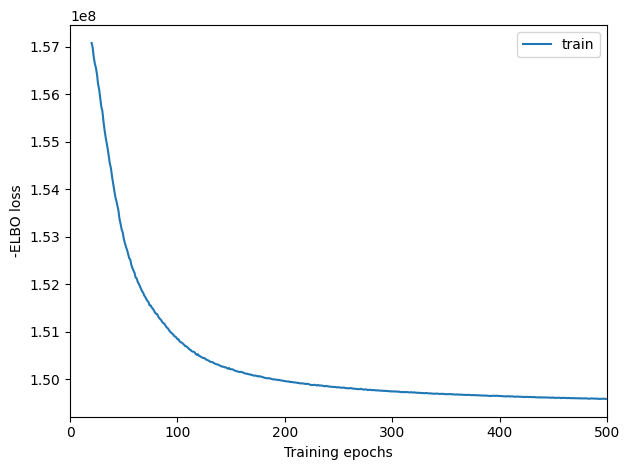

In [21]:

# mod.train(max_epochs=250, use_gpu=True)


mod.plot_history(20)

# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_ref = mod.export_posterior(
    # adata_ref, sample_kwargs={'num_samples': 1000, 'batch_size': 2500, 'use_gpu': True},
    adata_ref, sample_kwargs={'num_samples': 1000, 'batch_size': 2500},
    export_slot='mod',
    add_to_varm=["means","stds","q05","q95"]
)

# Save model
mod.save(f"{ref_run_name}", overwrite=True)

# Save anndata object with results
adata_file = f"{ref_run_name}/sc1.h5ad"
adata_ref.write(adata_file)
print(adata_ref.uns['mod']['factor_names'])


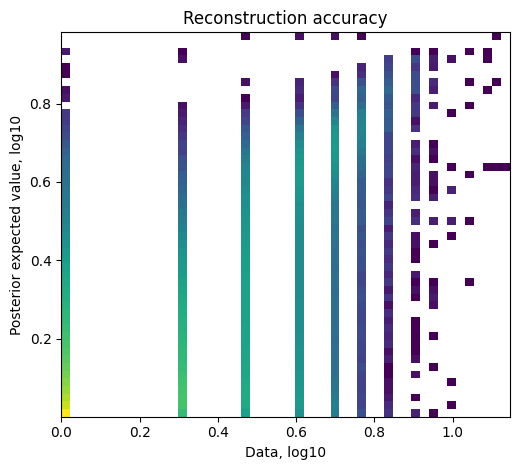

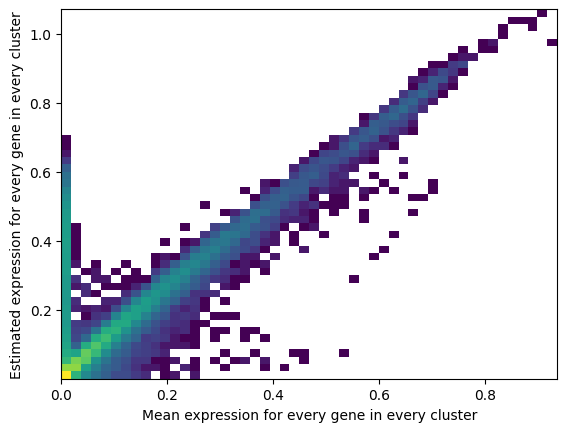

In [22]:
mod.plot_QC(summary_name='q95')

In [23]:
adata_ref.varm.keys()

KeysView(AxisArrays with keys: means_per_cluster_mu_fg, stds_per_cluster_mu_fg, q05_per_cluster_mu_fg, q95_per_cluster_mu_fg)

In [24]:
# export estimated expression in each cluster
if 'means_per_cluster_mu_fg' in adata_ref.varm.keys():
    inf_aver = adata_ref.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
else:
    inf_aver = adata_ref.var[[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
inf_aver.columns = adata_ref.uns['mod']['factor_names']
inf_aver.iloc[0:5, 0:5]

,B,CD8T,Endothelial,Fibroblasts,Malignant
RP11-34P13.7,0.579511,0.017041,0.116606,0.001895,0.003031
FO538757.2,0.019294,0.026844,0.027911,0.049091,0.032212
AP006222.2,0.006336,0.000919,0.002233,0.000521,0.001303
RP4-669L17.10,0.010341,0.001024,0.001903,0.000259,0.001737
RP11-206L10.9,0.009358,0.007541,0.001696,0.006032,0.003336


In [25]:
inf_aver

,B,CD8T,Endothelial,Fibroblasts,Malignant,Mono/Macro,Myofibroblasts,Plasma
RP11-34P13.7,0.579511,0.017041,0.116606,0.001895,0.003031,0.006319,0.327971,0.502951
FO538757.2,0.019294,0.026844,0.027911,0.049091,0.032212,0.041368,0.047916,0.022537
AP006222.2,0.006336,0.000919,0.002233,0.000521,0.001303,0.000946,0.049841,0.007686
RP4-669L17.10,0.010341,0.001024,0.001903,0.000259,0.001737,0.000375,0.004774,0.020813
RP11-206L10.9,0.009358,0.007541,0.001696,0.006032,0.003336,0.005393,0.064858,0.028780
...,...,...,...,...,...,...,...,...
AC007325.4,0.011333,0.012638,0.030145,0.005920,0.025624,0.026927,0.047029,0.036985
AC007325.2,0.042694,0.000672,0.003238,0.000199,0.000466,0.000432,0.003078,0.081662
AL354822.1,0.005230,0.003896,0.004910,0.006092,0.012211,0.001968,0.005157,0.024737
AC004556.1,0.024550,0.003967,0.007900,0.003194,0.005177,0.025478,0.008393,0.085096


In [33]:
# Deconvolution process
# find shared genes and subset both anndata and reference signatures
print(inf_aver)
print(adata_vis.X)

intersect = np.intersect1d(adata_vis.var_names, inf_aver.index)
print(intersect)
adata_vis = adata_vis[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()

# prepare anndata for cell2location model
# cell2location.models.Cell2location.setup_anndata(adata=adata_vis, batch_key="sample")
cell2location.models.Cell2location.setup_anndata(adata=adata_vis)


Empty DataFrame
Columns: [B, CD8T, Endothelial, Fibroblasts, Malignant, Mono/Macro, Myofibroblasts, Plasma]
Index: []
[]
[]


In [28]:
import pandas as pd

# Use the .drop_duplicates() method to remove duplicate variable names
adata_vis.var_names.drop_duplicates()

# Check if updated var_names are unique
is_unique_var_names = adata_vis.var_names.is_unique
print("adata_vis.var_names is unique：", is_unique_var_names)

adata_vis.var_names 是否唯一： True


In [29]:
# create and train the model
mod = cell2location.models.Cell2location(
    adata_vis, cell_state_df=inf_aver,
    # the expected average cell abundance: tissue-dependent
    # hyper-prior which can be estimated from paired histology:
    N_cells_per_location=30,
    # hyperparameter controlling normalisation of
    # within-experiment variation in RNA detection:
    detection_alpha=20
)
mod.view_anndata_setup()

ValueError: Please set up your AnnData with Cell2location.setup_anndata first.

In [ ]:
mod.train(max_epochs=5000,
          # train using full data (batch_size=None)
          batch_size=None,
          # use all data points in training because
          # we need to estimate cell abundance at all locations
          train_size=1
         )

# plot ELBO loss history during training, removing first 100 epochs from the plot
mod.plot_history(1000)
# plt.legend(labels=['full data training']);

In [ ]:
adata_vis

In [ ]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_vis = mod.export_posterior(
    adata_vis, sample_kwargs={'num_samples': 1000, 'batch_size': mod.adata.n_obs}
)

# Save model
mod.save(f"{run_name}", overwrite=True)

# mod = cell2location.models.Cell2location.load(f"{run_name}", adata_vis)

# Save anndata object with results
# adata_file = f"{run_name}/sp.h5ad"
# adata_vis.write(adata_file)# adata_file

In [ ]:

mod.plot_QC()


In [ ]:
# fig = mod.plot_spatial_QC_across_batches()
adata_vis

In [ ]:
adata_vis.obs[adata_vis.uns['mod']['factor_names']] = adata_vis.obsm['q05_cell_abundance_w_sf']
with mpl.rc_context({'axes.facecolor':  'black',
                     'figure.figsize': [4.5, 5]}):

    sc.pl.spatial(adata_vis, cmap='magma',
                  # 根据分析需求进行展示 细胞类型同样需要进行修改
                  # show first 8 cell types 
                  # color=['B', 'CD4Tconv', 'CD8T', 'CD8Tex', 'Mast', 'Mono/Macro', 'Myofibroblasts', 'NK', 'Plasma', 'Tprolif', 'Treg'],
                  color=[''],
                  ncols=4, size=1.3,
                  img_key='hires',
                  # limit color scale at 99.2% quantile of cell abundance
                  vmin=0, vmax='p99.2'
                 )
print(adata_vis.uns['mod']['factor_names'])

In [ ]:
adata_vis

In [ ]:
# The number here need to be intercepted according to your own data, and the intercepted part is the result of deconvolution
result =  adata_vis.obs.iloc[:, 24:]
result

In [ ]:
result.to_csv(r'E:\\PostGraduate\\newInformation\\output\\BRCA\\CID44971_cell2Location.csv', index=True)

In [ ]:
result